# Single character recognition model
- Our goal with this model is to use convolutional neural networks to recognize a single character on an image, similarly to what is done with the famous MNIST handwritten-digit dataset. In fact, we will use a very similar dataset called EMNIST, and more specifically the "balanced EMNIST" which contains a total of 112799 images. In this version, although much smaller than the real dataset, all characters are balanced, so they appear which more or less the same frequency. We thought this would make better predictions on the segmented words. 

In [30]:
### LOAD PACKAGES ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import random
from sklearn.utils import shuffle

In [31]:
### LOAD DATASET ### (already split when downloading)

train_file = pd.read_csv('data_2/emnist-balanced-train.csv')
train_file = np.array(train_file)
X_train = train_file[:,1:]
X_train = X_train.reshape((X_train.shape[0],28,28,1))
y_train = train_file[:,0]
y_train = y_train.reshape((y_train.shape[0],1))

test_file = pd.read_csv('data_2/emnist-balanced-test.csv')
test_file = np.array(test_file)
X_test = test_file[:,1:]
X_test = X_test.reshape((X_test.shape[0],28,28,1))
y_test = test_file[:,0]
y_test = y_test.reshape((y_test.shape[0],1))

print("Quick check on the shapes: ", X_train.shape, y_train.shape,X_test.shape,y_test.shape)

Quick check on the shapes:  (112799, 28, 28, 1) (112799, 1) (18799, 28, 28, 1) (18799, 1)


### Parsing the data
The dataset includes a mapping textfile which is used to map a character to its class label. Each class label (integers from 0 to n) is mapped to the ASCII representation of the character. 

In [32]:
### PARSE DATA ###

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
y_train = to_categorical(y_train.astype('uint8'))
y_test = to_categorical(y_test.astype('uint8'))
X_train, y_train = shuffle(X_train, y_train)

with open('data_2/emnist-balanced-mapping.txt','r') as mapp:
    d = dict()
    for l in mapp.readlines():
        d[int(l.split()[0])] = int(l.split()[1])

print(d)
print('Label range: ',np.min(y_train),np.max(y_train))

{0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53, 6: 54, 7: 55, 8: 56, 9: 57, 10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 19: 74, 20: 75, 21: 76, 22: 77, 23: 78, 24: 79, 25: 80, 26: 81, 27: 82, 28: 83, 29: 84, 30: 85, 31: 86, 32: 87, 33: 88, 34: 89, 35: 90, 36: 97, 37: 98, 38: 100, 39: 101, 40: 102, 41: 103, 42: 104, 43: 110, 44: 113, 45: 114, 46: 116}
Label range:  0.0 1.0


Let's display a few images to make sure the shuffling did not alter the labelling.

5


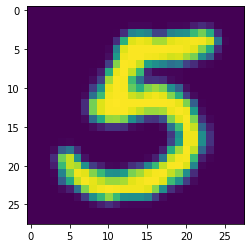

In [34]:
### DISPLAY ONE IMAGE ###

t = random.randint(0,100)
print(chr(d[np.argmax(y_train[t])]))
plt.imshow(X_train[t,:,:,0].T)


The model we define is a convolutional neural network with 3 filter layers. This model is similar to what one would use for the MNIST dataset. Since there are a bit more classes than the latter, we though that the model would work well if we added some complexity by adding filters throughout the layers. The rest is similar to what we implemented in TD.

In [38]:
def Model(input_shape, num_classes):
    
    model = keras.models.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64,activation ="relu"))
    model.add(Dense(128,activation ="relu"))
    model.add(Dense(num_classes,activation ="softmax"))
    
    model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [39]:
model = Model(X_train.shape[1:], y_train.shape[1])

In [37]:
def train(model, x: np.array, y: np.array,
                x_target: np.array, y_target: np.array,
                batch_size: int = 32, epochs: int = 10):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
    model.fit(x, y, batch_size=batch_size, epochs=epochs, callbacks=[e_stop], validation_data=(x_target, y_target))
    loss, accuracy = model.evaluate(x_target, y_target)

In [25]:
train(model,X_train,y_train,X_test,y_test,128,50)

Epoch 1/50
882/882 [==============================] - 46s 51ms/step - loss: 0.8636 - accuracy: 0.7351 - val_loss: 0.4981 - val_accuracy: 0.8332
Epoch 2/50
882/882 [==============================] - 31s 36ms/step - loss: 0.4364 - accuracy: 0.8472 - val_loss: 0.4238 - val_accuracy: 0.8521
Epoch 3/50
882/882 [==============================] - 35s 40ms/step - loss: 0.3736 - accuracy: 0.8682 - val_loss: 0.4091 - val_accuracy: 0.8589
Epoch 4/50
882/882 [==============================] - 45s 51ms/step - loss: 0.3424 - accuracy: 0.8761 - val_loss: 0.3757 - val_accuracy: 0.8675
Epoch 5/50
882/882 [==============================] - 45s 51ms/step - loss: 0.3173 - accuracy: 0.8827 - val_loss: 0.3644 - val_accuracy: 0.8711
Epoch 6/50
882/882 [==============================] - 45s 51ms/step - loss: 0.2990 - accuracy: 0.8889 - val_loss: 0.3600 - val_accuracy: 0.8742
Epoch 7/50
882/882 [==============================] - 44s 50ms/step - loss: 0.2839 - accuracy: 0.8922 - val_loss: 0.3503 - val_accuracy:

KeyboardInterrupt: 

In [26]:
model.save('model_char_v1')

INFO:tensorflow:Assets written to: model_char_v1/assets
